# <center>  **<span style="font-size:80px;">Graph Matching</span>** </center>

# <center> Universidad de Alicante </center>
<p align="center"><img src=".ipynb_gfx/UA.png" width="330" height="190"></p>
<br>

**Nombre:** Santiago Álvarez Geanta <br>
**Fecha:** 7 de febrero de 2025 <br>
**Grado:** Ingeniería en Inteligencia Artificial <br>
**Grupo:** 1 <br>


### Profesores
- Francisco Escolano Ruíz
- Ahmed Begga Hachlafi
<br>

# 1. Ejercicios

## 1.1 Ejercicio 1

A continuación vamos a implementar el Algoritmo Hungaro para el Graph Matching. Nuestro objetivo será encontrar la asignación/matcheo óptima de puntos entre dos imágenes. Usaremos la matriz de costes creada a partir de las distancias Uclídeas entre los puntos. Para resolver el problema utilizaremos la función `scipy.optimize.linear_sum_assignment`.

In [36]:
import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay 
from scipy.optimize import linear_sum_assignment

import pandas as pd
import os

In [37]:
def load_and_preprocess_images(img_path1, img_path2, mat_path1, mat_path2):
     
    img1 = Image.open(img_path1) 
    img2 = Image.open(img_path2) 

    kpts1 = np.array(sio.loadmat(mat_path1)["pts_coord"])
    kpts2 = np.array(sio.loadmat(mat_path2)["pts_coord"])

    return img1, img2, kpts1.T, kpts2.T

In [38]:
def delaunay_triangulation(kpt):
    
    tri = Delaunay(kpt)

    n = len(kpt)
    A = np.zeros((n, n), dtype=int)
    
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                p1, p2 = simplex[i], simplex[j]
                A[p1, p2] = A[p2, p1] = 1
    
    return A

In [39]:
def simple_spatial_matching(kpts1, kpts2):

    # kpts1  # Shape: (n, 2)
    # kpts2.T  # Shape: (m, 2)
    
    # Matriz de coste: Distancias Euclideas entre cada par de keypoints
    cost_matrix = np.linalg.norm(kpts1[:, np.newaxis, :] - kpts2[np.newaxis, :, :], axis=2)
    
    # Apicamos el Algoritmo Hungaro para obtener las asignación optima entre cada par de puntos
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Matriz de matching (el 1 indica una conexiçón entre cada par de puntos)
    matching = np.zeros(cost_matrix.shape, dtype=int)
    matching[row_ind, col_ind] = 1
    
    return matching

### Visualización

In [40]:
### VISUALIZACIÓN

def resize_to_same_height(img1, img2, kpts1, kpts2):
    # Obtener tamaños originales
    h1, w1 = img1.size[1], img1.size[0]
    h2, w2 = img2.size[1], img2.size[0]

    # Encontrar la altura máxima
    max_height = max(h1, h2)

    # Calcular factores de escala
    scale1 = max_height / h1
    scale2 = max_height / h2

    # Calcular nuevos anchos manteniendo la proporción
    new_w1 = int(w1 * scale1)
    new_w2 = int(w2 * scale2)

    # Redimensionar imágenes
    img1_resized = img1.resize((new_w1, max_height), Image.LANCZOS)
    img2_resized = img2.resize((new_w2, max_height), Image.LANCZOS)

    # Ajustar keypoints con los mismos factores de escala
    kpts1_resized = kpts1 * scale1
    kpts2_resized = kpts2 * scale2

    return img1_resized, img2_resized, kpts1_resized, kpts2_resized

def visualize_matching_full(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    # Asegurar que imágenes y keypoints tengan la misma escala
    img1, img2, kpts1, kpts2 = resize_to_same_height(img1, img2, kpts1, kpts2)

    img1_np = np.array(img1)
    img2_np = np.array(img2)
    
    combined_img = np.hstack((img1_np, img2_np))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(combined_img)

    row_idx, col_idx = np.where(matching)


    for i, j in zip(row_idx, col_idx):
        x1, y1 = kpts1[i]
        x2, y2 = kpts2[j] + np.array([img1_np.shape[1], 0])  # Ajustar x para la segunda imagen

        color = "green" if i == j else "red"
     
        ax.plot(x1, y1, 'ro')
        ax.plot(x2, y2, 'bo')
        ax.plot([x1, x2], [y1, y2], '-', color=color, linewidth=1.5)

    # Dibujar aristas del grafo con keypoints escalados
    draw_graph_edges(ax, kpts1, adj_matrix1, color="yellow")
    draw_graph_edges(ax, kpts2 + np.array([img1_np.shape[1], 0]), adj_matrix2, color="yellow")

    ax.axis('off')
    plt.show()

def draw_graph_edges(ax, keypoints, adj_matrix, color="yellow"):
    """Dibuja las aristas del grafo dado un conjunto de keypoints y una matriz de adyacencia."""
    num_points = keypoints.shape[0]
    for i in range(num_points):
        for j in range(i + 1, num_points):
            if adj_matrix[i, j]:  # Si hay conexión en la matriz de adyacencia
                x1, y1 = keypoints[i]
                x2, y2 = keypoints[j]
                ax.plot([x1, x2], [y1, y2], color=color, linestyle='-', linewidth=0.5)


### Evaluación

In [45]:
def evaluate_matching(kpts1, kpts2, matching):

    num_kpts = kpts1.shape[0]
    if num_kpts != kpts2.shape[0] or num_kpts < 0:
        return 0
    
    correct_matches = np.sum(np.diag(matching))  
    accuracy = correct_matches / num_kpts
    return accuracy

### CSV

In [ ]:
def writeCSV(results, output_csv="results.csv"):
    try:
        df = pd.DataFrame([results], columns=["Category", "Mean Accuracy", "Std_Deviation", "Number_of_Images"])
        

        if os.path.exists(output_csv):
            df.to_csv(output_csv, mode='a', header=False, index=False)
        else:
            df.to_csv(output_csv, mode='w', header=True, index=False)
        
        print(f"Resultados guardados en {output_csv}")
    except Exception as e:
        print(f"Error al guardar el archivo CSV: {e}")

# Algoritmo Húngaro

In [42]:
def main(filePath1, filePath2, category, plot=False):
    
    img1, img2, kpts1, kpts2 = load_and_preprocess_images(img_path1= filePath1+".png", img_path2= filePath2+".png",
                                                            mat_path1= filePath1+".mat", mat_path2= filePath2+".mat")
    
    A1 = delaunay_triangulation(kpt= kpts1)
    A2 = delaunay_triangulation(kpt = kpts2)

    matching = simple_spatial_matching(kpts1= kpts1, kpts2= kpts2)

    if plot:
        plt.figure(figsize= (16, 7))
        visualize_matching_full(img1= img1, img2= img2,
                                kpts1= kpts1, kpts2= kpts2,
                                adj_matrix1= A1, adj_matrix2= A2,
                                matching= matching)
    
    return kpts1, kpts2, matching

<Figure size 1600x700 with 0 Axes>

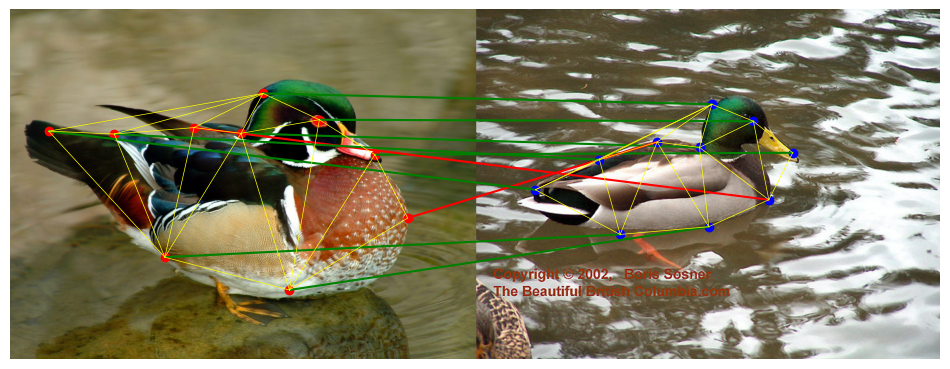

<Figure size 1600x700 with 0 Axes>

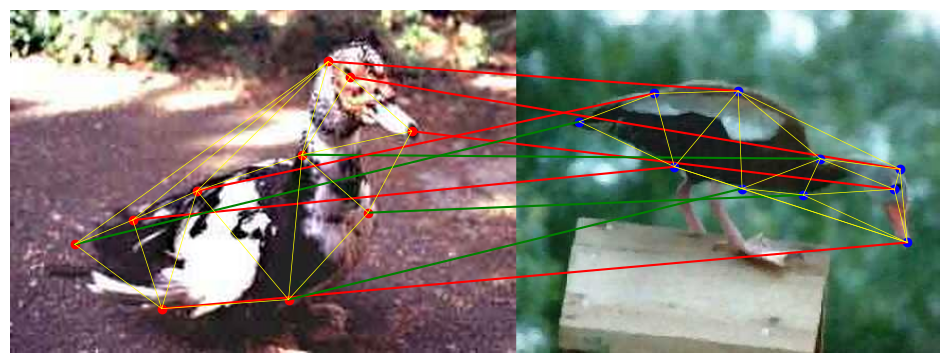

In [46]:
filePathDuck = "data/WillowObject/WILLOW-ObjectClass/Duck/"

for (img1, img2) in [("01","05"), ("17","38")]:
    main(filePathDuck+f"060_00{img1}", filePathDuck+f"060_00{img2}", category="Duck", plot= True)

In [44]:
dataPath = "data/WillowObject/WILLOW-ObjectClass/"
categories = ["Duck", "Car", "Face", "Motorbike", "Winebottle"]
num_images = 0

for category in categories:
    accuracies = list()
    files = os.listdir(dataPath + category + "/")
    files = [os.path.splitext(file)[0] for file in files if file.endswith('.png')]

    for i in range(len(files)):
        for j in range(i + 1, len(files)):  
            num_images += 1
            kpts1, kpts2, matching = main(filePath1= dataPath+category+"/"+files[i], filePath2= dataPath+category+"/"+files[j], category= category)
            accuracies.append(evaluate_matching(kpts1= kpts1, kpts2= kpts2, matching= matching))

    writeCSV(results=[f"{category}", np.mean(accuracies), np.std(accuracies), str(num_images)])
    accuracies = list()
    num_images = 0

Resultados guardados en results.csv
Resultados guardados en results.csv
Resultados guardados en results.csv
Resultados guardados en results.csv
Resultados guardados en results.csv


### <center>Santiago Álvarez Geanta</center>
#### <center>Universidad de Alicante</center>
<p align="center"><img src=".ipynb_gfx/UA.png" width="165" height="95"></p>